## Import libraries

In [1]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
import math

import datetime

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

from Py6S import *
from atmospheric import Atmospheric

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.feature_selection import f_classif
from shapely.geometry import Polygon
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Deep learning libraries
# import torch
# from torchvision import datasets, models, transforms

In [2]:
print(ee.__version__)

# Melakukan Autentikasi Pengguna. Klik link yang muncul, kemudian copykan
# token yang diperoleh ke kolom yang tersedia
ee.Authenticate()

# Mengaktifkan GEE pada Google Colab
ee.Initialize(project='ee-atlk')

1.4.0


## Daerah prediksi

### Buat polygon daerah yang ingin diprediksi

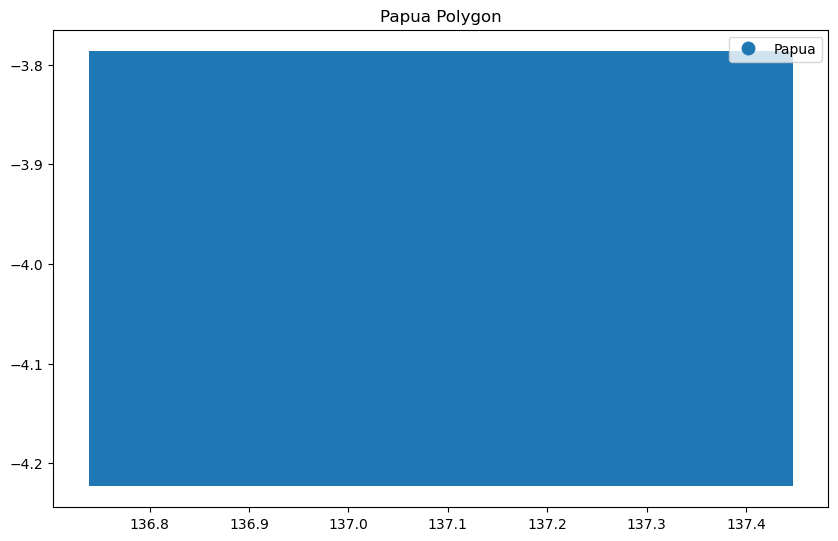

In [3]:
# Define the Papua polygon as a Shapely Polygon
papua_polygon = Polygon([
    [136.73882872937395, -3.786814553953561],
    [136.73882872937395, -4.222453776757516],
    [137.44744689343645, -4.222453776757516],
    [137.44744689343645, -3.786814553953561]
])
# Create a GeoDataFrame for the polygon
papua_gdf = gpd.GeoDataFrame({'shapeName': ['Papua'], 'geometry': [papua_polygon]}, crs="EPSG:4326")

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, figsize=(10, 10))
papua_gdf.plot('shapeName', legend=True, ax=ax)

# Set the plot title and show the plot
ax.set_title("Papua Polygon")
plt.show()

### Buat tampilan citra satelit yang ingin diprediksi

In [4]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10,
    method='min'
):
    """
    Generates a cloud-filtered, aggregated Sentinel-2 image from Google Earth Engine 
    using the Python Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID.
        You can find the full list of ImageCollection IDs at
        https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images.
      max_date (str): Maximum date to acquire collection of satellite images.
      range_min (int): Minimum value for visualization range.
      range_max (int): Maximum value for visualization range.
      cloud_pct (float): The cloud cover percent to filter by (default 10).
      aggregation_method (str): Method for aggregating the ImageCollection.
        Options: 'mean', 'median', 'min', 'max' (default: 'median').

    Returns:
      ee.image.Image: Aggregated Sentinel-2 image clipped to the region of interest.
    """
    # Filter the ImageCollection
    collection = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))
    
    # Select aggregation method
    if method == 'mean':
        image = collection.mean()
    elif method == 'median':
        image = collection.median()
    elif method == 'min':
        image = collection.min()
    elif method == 'max':
        image = collection.max()
    else:
        raise ValueError("Invalid aggregation_method. Choose from 'mean', 'median', 'min', 'max'.")

    # Select a representative image (e.g., the one with the least cloud cover)
    representative_image = collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()

    # Extract metadata from the representative image
    representative_properties = representative_image.toDictionary().getInfo()

    # Extract `system:time_start` from the representative image
    time_start = representative_image.get('system:time_start')

    # Attach properties and `system:time_start` to the aggregated image
    image = image.set(representative_properties).set('system:time_start', time_start)

    # Clip the image to the region
    return image.clip(region)


In [5]:
# Get the centroid of the polygon
centroid = papua_polygon.centroid.coords[0]
papua_region = eec.gdfToFc(papua_gdf) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    papua_region,
    product='COPERNICUS/S2_HARMONIZED', # Sentinel-2A
    min_date='2024-01-01', # Get all images within
    max_date='2024-12-31', # the year 2021
    range_max=3000,
    cloud_pct=50, # Filter out images with cloud cover >= 10.0%
    method='min'
)
print(type(image))
# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10,zoomScrollWheel=False)
Map.addLayer(image.visualize(bands=['B4', 'B3', 'B2'], min=0, max=2000), {}, 'Sentinel2')
Map.addLayerControl()
Map

<class 'ee.image.Image'>


### Atmosphere correction

In [6]:
def spectralResponseFunction(bandname):
    """
    Extract spectral response function for given band name
    """
    bandSelect = {
        'B1':PredefinedWavelengths.S2A_MSI_01,
        'B2':PredefinedWavelengths.S2A_MSI_02,
        'B3':PredefinedWavelengths.S2A_MSI_03,
        'B4':PredefinedWavelengths.S2A_MSI_04,
        'B5':PredefinedWavelengths.S2A_MSI_05,
        'B6':PredefinedWavelengths.S2A_MSI_06,
        'B7':PredefinedWavelengths.S2A_MSI_07,
        'B8':PredefinedWavelengths.S2A_MSI_08,
        'B8A':PredefinedWavelengths.S2A_MSI_8A,
        'B9':PredefinedWavelengths.S2A_MSI_09,
        'B10':PredefinedWavelengths.S2A_MSI_10,
        'B11':PredefinedWavelengths.S2A_MSI_11,
        'B12':PredefinedWavelengths.S2A_MSI_12,
        }
    return Wavelength(bandSelect[bandname])

In [7]:
def toa_to_rad(info, solar_z, scene_date, toa, bandname):
    """
    Converts top of atmosphere reflectance to at-sensor radiance
    """
    
    # solar exoatmospheric spectral irradiance
    ESUN = info['SOLAR_IRRADIANCE_'+bandname]
    solar_angle_correction = math.cos(math.radians(solar_z))
    
    # Earth-Sun distance (from day of year)
    doy = scene_date.timetuple().tm_yday
    d = 1 - 0.01672 * math.cos(0.9856 * (doy-4))# http://physics.stackexchange.com/questions/177949/earth-sun-distance-on-a-given-day-of-the-year
   
    # conversion factor
    multiplier = ESUN*solar_angle_correction/(math.pi*d**2)

    # at-sensor radiance
    rad = toa.select(bandname).multiply(multiplier)
    
    return rad

In [8]:
def surface_reflectance(info, solar_z, scene_date, toa, s, bandname):
    """
    Calculate surface reflectance from at-sensor radiance given waveband name
    """
    
    # run 6S for this waveband
    s.wavelength = spectralResponseFunction(bandname)
    s.run()
    
    # extract 6S outputs
    Edir = s.outputs.direct_solar_irradiance             #direct solar irradiance
    Edif = s.outputs.diffuse_solar_irradiance            #diffuse solar irradiance
    Lp   = s.outputs.atmospheric_intrinsic_radiance      #path radiance
    absorb  = s.outputs.trans['global_gas'].upward       #absorption transmissivity
    scatter = s.outputs.trans['total_scattering'].upward #scattering transmissivity
    tau2 = absorb*scatter                                #total transmissivity
    
    # radiance to surface reflectance
    rad = toa_to_rad(info, solar_z, scene_date, toa, bandname)
    ref = rad.subtract(Lp).multiply(math.pi).divide(tau2*(Edir+Edif))
    
    return ref

In [9]:
def atmos_corr(image, start_date):
    info = image.getInfo()['properties']
    scene_date = datetime.datetime.utcfromtimestamp(info['system:time_start']/1000)# i.e. Python uses seconds, EE uses milliseconds
    solar_z = info['MEAN_SOLAR_ZENITH_ANGLE']

    toa = image.divide(10000)
    date = ee.Date(str(start_date))
    geom = ee.Geometry.Point(centroid)

    h2o = Atmospheric.water(geom,date).getInfo()
    o3 = Atmospheric.ozone(geom,date).getInfo()
    aot = Atmospheric.aerosol(geom,date).getInfo()

    SRTM = ee.Image('CGIAR/SRTM90_V4')# Shuttle Radar Topography mission covers *most* of the Earth
    alt = SRTM.reduceRegion(reducer = ee.Reducer.mean(),geometry = geom.centroid()).get('elevation').getInfo()
    km = alt/1000 # i.e. Py6S uses units of kilometers

    # Instantiate
    s = SixS()

    # Atmospheric constituents
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3)
    s.aero_profile = AeroProfile.Continental
    s.aot550 = aot

    # Earth-Sun-satellite geometry
    s.geometry = Geometry.User()
    s.geometry.view_z = 0               # always NADIR (I think..)
    s.geometry.solar_z = solar_z        # solar zenith angle
    s.geometry.month = scene_date.month # month and day used for Earth-Sun distance
    s.geometry.day = scene_date.day     # month and day used for Earth-Sun distance
    s.altitudes.set_sensor_satellite_level()
    s.altitudes.set_target_custom_altitude(km)

    # surface reflectance rgb
    b = surface_reflectance(info, solar_z, scene_date, toa, s, 'B2')
    g = surface_reflectance(info, solar_z, scene_date, toa, s, 'B3')
    r = surface_reflectance(info, solar_z, scene_date, toa, s, 'B4')
    ref_clipped = r.addBands(g).addBands(b).clip(papua_region)

    # all wavebands
    output = image.select('QA60')
    for band in ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12']:
        print(band)
        output = output.addBands(surface_reflectance(info, solar_z, scene_date, toa, s, band))

    # Convert output bands to Float32
    output = output.toFloat()

    # Define the visualization region
    region = papua_region.bounds().getInfo()['coordinates']  # Get bounding box

    # Visualization parameters
    thumb_params = {
        'region': region,
        'min': 0,
        'max': 0.25,  # Adjust visualization range based on reflectance values
        'dimensions': 1000
    }

    # Generate URLs
    url_corrected = ref_clipped.select(['B4', 'B3', 'B2']).getThumbUrl(thumb_params)
    print("Corrected Image Thumbnail URL:", url_corrected)
    return output


In [10]:
corrected_image = atmos_corr(image, '2024-01-01')
task = ee.batch.Export.image.toDrive(
    image=corrected_image,
    description='Surface_Reflectance_Corrected',
    folder='GEE_Exports',
    fileNamePrefix='corrected_image_papua_2024',
    region=papua_region.bounds().getInfo()['coordinates'],
    scale=10,
    maxPixels=1e13
)
task.start()


c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD08_M3! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD08_M3

  warnings.warn(warning, category=DeprecationWarning)


B1
B2
B3
B4
B5
B6
B7
B8
B8A
B9
B10
B11
B12
Corrected Image Thumbnail URL: https://earthengine.googleapis.com/v1/projects/ee-atlk/thumbnails/65d7f7ad5858502792e2d004da5237d0-002562defc486f335382ec011e7c9478:getPixels


### Visualisasi image yang sudah diexport

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


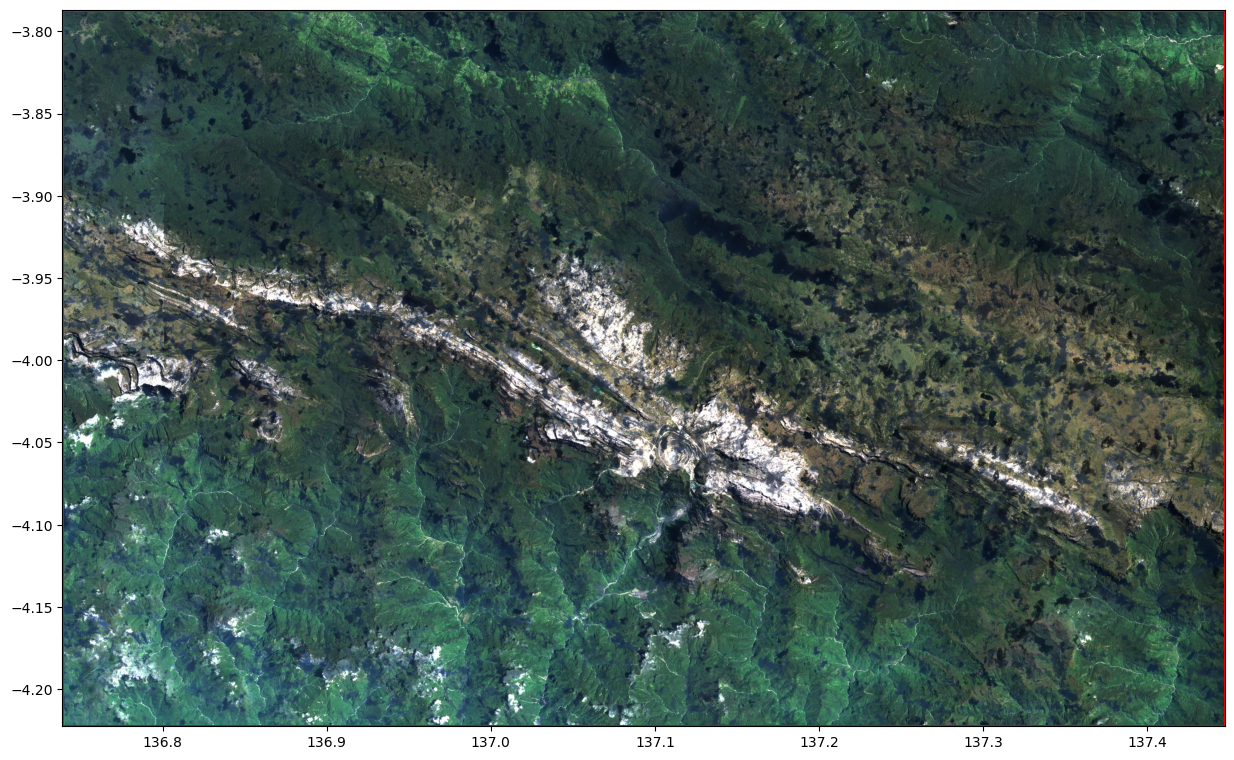

In [11]:
# Set file path
tif_file = ('../data/atmos corr/corrected_image_papua_2024.tif')

# Open the image file using Rasterio
image = rio.open(tif_file)

# Get the bounding box in the image's coordinate system
bounds = image.bounds
crs = image.crs  # get the CRS

# Create a Shapely box (polygon) from the bounds
tif_boundary = gpd.GeoDataFrame({'geometry': [box(bounds.left, bounds.bottom, bounds.right, bounds.top)]}, crs=crs)

# Initialize a plot for all images and boundaries
fig, ax = plt.subplots(figsize=(15, 15))

# Read bands 4, 3, and 2 (assuming they're in this order: band1 -> index 1, band2 -> index 2, etc.)
rgb = image.read([5, 4, 3])  # Reading bands 4, 3, and 2

# Normalize to range [0, 1]
rgb = rgb / 0.1  # Adjust divisor based on your data's max value
rgb = np.clip(rgb, 0, 1)  # Clip values to ensure they are within [0, 1]

# Display the RGB composite and plot the boundary
show(rgb, ax=ax, transform=image.transform)
tif_boundary.plot(facecolor="none", edgecolor='red', linewidth=2, ax=ax)

plt.show()

In [12]:
# Open the image file
with rio.open(tif_file) as image:
    # Get the number of bands
    num_bands = image.count
    print(f"Number of bands: {num_bands}")
    
    # List descriptions for each band
    for i in range(1, num_bands + 1):  # Bands are 1-indexed in Rasterio
        desc = image.descriptions[i - 1]
        print(f"Band {i}: {desc if desc else 'No description available'}")

Number of bands: 14
Band 1: QA60
Band 2: B1
Band 3: B2
Band 4: B3
Band 5: B4
Band 6: B5
Band 7: B6
Band 8: B7
Band 9: B8
Band 10: B8A
Band 11: B9
Band 12: B10
Band 13: B11
Band 14: B12


### Load data image

In [13]:
# Load sentinel image
# Define the list of TIF file paths
tif_image = rio.open(tif_file)
# Read the image and normalize it by dividing by 1e4
image_data = tif_image.read() / 1e4

## Hasil labeling

### Import hasil labeling

In [14]:
with open ('../data/tambang_papua.geojson', 'r') as file:
    sample_data = geojson.load(file)

# # Now, let's print the GeoJSON data to understand its structure
# pp.pprint(dict(sample_data))

sample_data['features'][0]['properties']['name'] = 'tambang'
sample_data['features'][1]['properties']['name'] = 'non_tambang'
sample_data['features'][0]['properties']['label'] = '1'
sample_data['features'][1]['properties']['label'] = '0'

### Ubah menjadi dataframe

In [15]:
# Initialize a list to hold the data
data = []

# Iterate over each feature in the GeoJSON
for feature in sample_data['features']:
    # Extract coordinates (for MultiPoint, it's a list of points)
    coordinates = feature['geometry']['coordinates']

    # Extract label from properties
    label = feature['properties']['label']
    name = feature['properties']['name']

    # Iterate over the points in the MultiPoint geometry
    for coord in coordinates:
        # Append a dictionary with the coordinates and label
        data.append({
            'longitude': coord[0],
            'latitude': coord[1],
            'label': label,
            'name': name
        })

# Create a DataFrame from the data list
sample = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(sample.head())
print(sample.shape)

    longitude  latitude label     name
0  107.586895 -3.004447     1  tambang
1  107.589878 -3.004222     1  tambang
2  107.590961 -3.001790     1  tambang
3  137.037831 -4.023746     1  tambang
4  137.015858 -3.996347     1  tambang
(1000, 4)


In [16]:
# Initialize a list to hold the data
coords = []

# Iterate over each feature in the GeoJSON
for feature in sample_data['features']:
    # Extract coordinates (for MultiPoint, it's a list of points)
    coordinates = feature['geometry']['coordinates']

    # Extract label from properties
    # label = feature['properties']['label']

    # Iterate over the points in the MultiPoint geometry
    for coord in coordinates:
        # Append a dictionary with the coordinates and label
        coords.append((coord[0], coord[1]))

print(coords)

[(107.586895, -3.004447), (107.589878, -3.004222), (107.590961, -3.00179), (137.037831, -4.023746), (137.015858, -3.996347), (137.063237, -4.040185), (137.132588, -4.03128), (137.1731, -4.059363), (137.156621, -4.077855), (137.337895, -4.080595), (137.349568, -4.088814), (136.901875, -3.965523), (136.924534, -3.966893), (136.936894, -4.025801), (137.312489, -4.062102), (137.305303, -4.068716), (137.319551, -4.076507), (137.180391, -4.037115), (137.185198, -4.041567), (137.166315, -4.029666), (137.146316, -4.042595), (137.092758, -4.060574), (137.091213, -4.050471), (137.111555, -4.056721), (137.080249, -4.048759), (137.06377, -4.031978), (137.046766, -4.029564), (137.042903, -4.043948), (137.030887, -4.009016), (137.023162, -4.016208), (137.077078, -4.010879), (137.085232, -4.008996), (137.08918, -3.99855), (137.081756, -3.994654), (137.061742, -3.98366), (137.065532, -3.958829), (137.065189, -3.968076), (136.977678, -3.989728), (136.960511, -3.982364), (136.870561, -3.959588), (136.94

In [17]:
from shapely.geometry import Point

# Check if coordinates are out of bounds
out_of_bounds = []
for coord in coords:
    point = Point(coord)  # Create a Point geometry
    if not papua_polygon.contains(point):  # Check if point is inside the polygon
        out_of_bounds.append(coord)

print("Out of bounds coordinates:")
print(out_of_bounds)

Out of bounds coordinates:
[(107.586895, -3.004447), (107.589878, -3.004222), (107.590961, -3.00179)]


### Extract raster values

,longitude,latitude,label,name,QA60,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
0,107.586895,-3.004447,1,tambang,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,107.589878,-3.004222,1,tambang,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2,107.590961,-3.001790,1,tambang,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,137.037831,-4.023746,1,tambang,0.0,0.000007,0.000007,0.000006,0.000007,0.000007,0.000008,0.000008,0.000010,0.000010,0.000015,8.538922e-06,0.000019,0.000016
4,137.015858,-3.996347,1,tambang,0.0,0.000006,0.000006,0.000005,0.000005,0.000005,0.000006,0.000007,0.000007,0.000008,0.000009,4.361556e-06,0.000011,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,137.181424,-3.846789,0,non_tambang,0.0,0.000003,0.000002,0.000002,0.000002,0.000004,0.000011,0.000012,0.000014,0.000014,0.000012,1.841885e-07,0.000007,0.000003
996,137.327680,-3.837541,0,non_tambang,0.0,0.000003,0.000002,0.000002,0.000001,0.000003,0.000010,0.000013,0.000012,0.000014,0.000011,1.841885e-07,0.000007,0.000003
997,137.389478,-3.857066,0,non_tambang,0.0,0.000002,0.000001,0.000001,0.000001,0.000002,0.000004,0.000004,0.000004,0.000005,0.000004,-5.120393e-07,0.000002,0.000002
998,136.932172,-3.858094,0,non_tambang,0.0,0.000003,0.000002,0.000003,0.000002,0.000005,0.000014,0.000017,0.000016,0.000019,0.000014,-1.208267e-06,0.000010,0.000004


c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


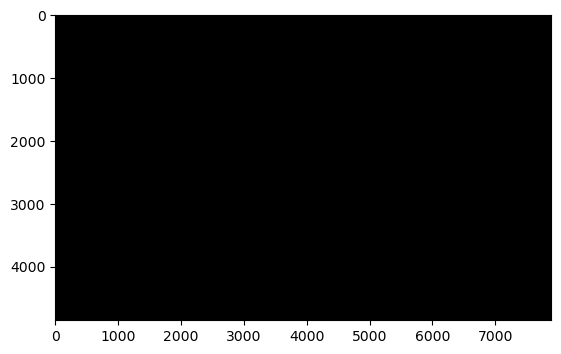

In [18]:
from skimage.exposure import rescale_intensity
sample_extract = sample.copy()

# False color composite
out_range = (0, 1)
red = rescale_intensity(image_data[4], in_range=(0, 10000), out_range=out_range)  # Band 4 (Red)
green = rescale_intensity(image_data[3], in_range=(0, 10000), out_range=out_range)  # Band 3 (Green)
blue = rescale_intensity(image_data[2], in_range=(0, 10000), out_range=out_range)  # Band 2 (Blue)

arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot image
plt.imshow(composite)

# Extract raster value
raster_extract = np.stack(
    [x for x in tif_image.sample(coords)]
) / 1e4
sample_extract[['QA60', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']] = raster_extract
sample_extract

In [19]:
print("Shape of raster_extract:", raster_extract.shape)


Shape of raster_extract: (1000, 14)


### Sample split

In [20]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 700
Test size: 300


## Modeling

### Buat model menggunakan Random Forest

In [21]:
# Make random forest model
predictors = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
model = RandomForestClassifier(50)
model.fit(
    train[predictors],
    train['label']
)

RandomForestClassifier(n_estimators=50)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       151
           1       0.97      0.97      0.97       149

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



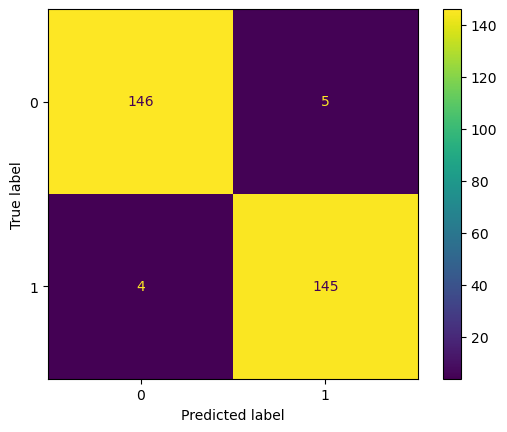

In [22]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['label'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['label'], test_apply)
print(report)

### Aplikasikan model ke citra

In [23]:
# Load image
image_transpose = image_data.T
transpose_shape = image_transpose.shape
band_names = ['QA60', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=band_names,
)
table_image

,QA60,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
0,0.0,0.000003,0.000003,0.000003,0.000002,0.000003,0.000006,0.000006,0.000008,0.000008,0.000006,1.841885e-07,0.000005,0.000004
1,0.0,0.000003,0.000003,0.000003,0.000002,0.000003,0.000006,0.000008,0.000009,0.000009,0.000006,1.841885e-07,0.000004,0.000003
2,0.0,0.000003,0.000003,0.000002,0.000002,0.000003,0.000006,0.000008,0.000009,0.000009,0.000006,1.841885e-07,0.000004,0.000003
3,0.0,0.000003,0.000003,0.000002,0.000002,0.000002,0.000006,0.000006,0.000007,0.000007,0.000006,1.841885e-07,0.000004,0.000002
4,0.0,0.000003,0.000002,0.000002,0.000002,0.000002,0.000006,0.000006,0.000007,0.000007,0.000006,1.841885e-07,0.000004,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38277423,0.0,0.000003,0.000002,0.000002,0.000002,0.000004,0.000012,0.000014,0.000014,0.000016,0.000010,-1.208267e-06,0.000007,0.000003
38277424,0.0,0.000003,0.000002,0.000002,0.000001,0.000003,0.000008,0.000012,0.000012,0.000013,0.000010,-1.208267e-06,0.000006,0.000003
38277425,0.0,0.000003,0.000002,0.000002,0.000001,0.000003,0.000008,0.000012,0.000009,0.000013,0.000010,-1.208267e-06,0.000006,0.000003
38277426,0.0,0.000003,0.000002,0.000002,0.000001,0.000004,0.000010,0.000012,0.000012,0.000015,0.000010,-1.208267e-06,0.000006,0.000003


In [24]:
table_image.to_csv('../data/table_image_S2.csv', index=False)

In [25]:
table_image = pd.read_csv('../data/table_image_S2.csv')

In [26]:
table_image = table_image.drop(columns=['QA60'])

In [27]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a strategy to fill NaNs, e.g., with the mean value
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
table_image_imputed = imputer.fit_transform(table_image[predictors])

# Predict with the imputed data
prediction = model.predict(table_image_imputed)
prediction

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['1', '0', '0', ..., '0', '0', '0'], dtype=object)

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


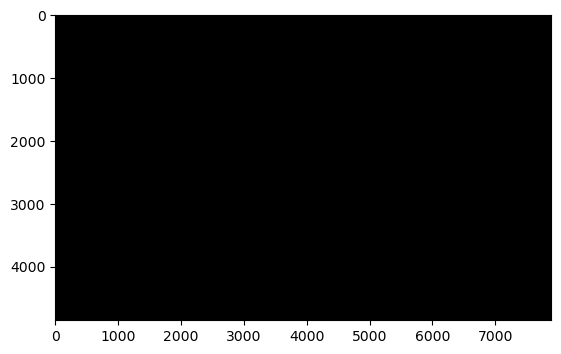

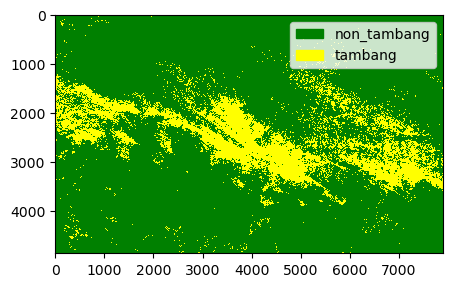

In [28]:
out_range = (0, 1)
red = rescale_intensity(image_data[3], in_range=(0, 0.3), out_range=out_range)  # Band 4 (Red)
green = rescale_intensity(image_data[2], in_range=(0, 0.3), out_range=out_range)  # Band 3 (Green)
blue = rescale_intensity(image_data[1], in_range=(0, 0.3), out_range=out_range)  # Band 2 (Blue)

arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Prediction to image again
prediction = np.array(prediction, dtype=int) 
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

cmap = ListedColormap(['green', 'yellow'])
legend_labels = [mpatches.Patch(color='green', label='non_tambang'), 
                    mpatches.Patch(color='yellow', label='tambang')]

# Show to plot
plt.figure(figsize=(5, 5))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(handles=legend_labels, loc='upper right')

### Prediksi menggunakan NDVI

In [30]:
# Calculate NDVI and handle division by zero
train['NDVI'] = np.where(
    (train['B8'] + train['B4']) == 0,  # Check where the denominator is zero
    0,  # Assign NDVI = 0 where denominator is zero
    (train['B8'] - train['B4']) / (train['B8'] + train['B4'])
)

# Check if there are still any NaN values
if train['NDVI'].isnull().any():
    print("There are still NaN values. These will be filled with 0.")
    train['NDVI'] = train['NDVI'].fillna(0)  # Replace any remaining NaNs with 0

# Replace predictors with only NDVI
predictors = ['NDVI']

# Train the Random Forest model using NDVI
model = RandomForestClassifier(50)
model.fit(
    train[predictors],
    train['label']
)


RandomForestClassifier(n_estimators=50)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       151
           1       0.77      0.82      0.79       149

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



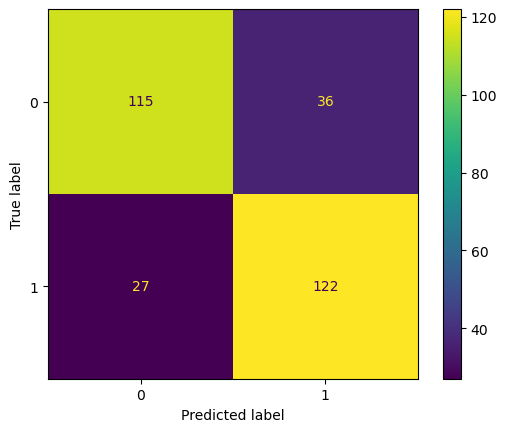

In [ ]:
# Calculate NDVI and handle division by zero
test['NDVI'] = np.where(
    (test['B8'] + test['B4']) == 0,  # Check where the denominator is zero
    0,  # Assign NDVI = 0 where denominator is zero
    (test['B8'] - test['B4']) / (test['B8'] + test['B4'])
)

# Check if there are still any NaN values
if test['NDVI'].isnull().any():
    print("There are still NaN values. These will be filled with 0.")
    test['NDVI'] = test['NDVI'].fillna(0)  # Replace any remaining NaNs with 0

# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['label'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['label'], test_apply)
print(report)

In [37]:
# Calculate NDVI and handle division by zero
table_image['NDVI'] = np.where(
    (table_image['B8'] + table_image['B4']) == 0,  # Check where the denominator is zero
    0,  # Assign NDVI = 0 where denominator is zero
    (table_image['B8'] - table_image['B4']) / (table_image['B8'] + table_image['B4'])
)

In [38]:
# Create an imputer object with a strategy to fill NaNs, e.g., with the mean value
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
table_image_imputed = imputer.fit_transform(table_image[predictors])

# Predict with the imputed data
prediction = model.predict(table_image_imputed)
prediction

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

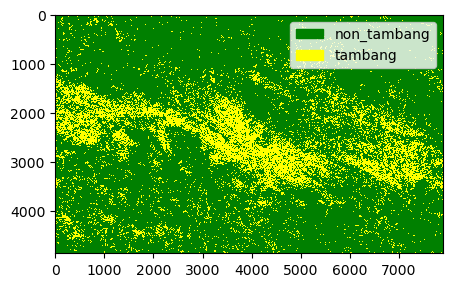

In [39]:
# Prediction to image again
prediction = np.array(prediction, dtype=int) 
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

cmap = ListedColormap(['green', 'yellow'])
legend_labels = [mpatches.Patch(color='green', label='non_tambang'), 
                    mpatches.Patch(color='yellow', label='tambang')]

# Show to plot
plt.figure(figsize=(5, 5))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(handles=legend_labels, loc='upper right')

In [40]:
import pickle

# Save the trained model to a file
with open('random_forest_ndvi_model.pkl', 'wb') as file:
    pickle.dump(model, file)
